# Comparing Optimization Results using Active Subspaces and Derivative-Free Optimization on a Function with Additive Noise

In [1]:
# Import needed packages

import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Number of samples for active subspace computation
M = 1000

# The input matrix
a = np.random.uniform(low=-1, high=1, size=(M,11))



# An M x 1 column vector containing the evaluations of f at data points 1,...,M
def fun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5];
    x1 = a[:,6]; x2=a[:,7]; x3=a[:,8]; x4=a[:,9]; x5=a[:,10]
    
    return (x**2+0.5*y**2+4*z**2+(1/8)*w**2+16*p**2+(1/32)*q**2+64*x1**2+(1/128)*x2**2+256*x3**2+(1/512)*x4**2+1024*x5**2).reshape(M, 1)

    


f=fun(a)


# Global noise proportionality constant
k = 1e-4

# Perturbed function output
pert_f=f+k*(2*(np.random.rand(M,1))-np.ones((M,1)))





# Computation of the Active Subspace

active_subspaces/gradients.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u = np.linalg.lstsq(A, b)[0]


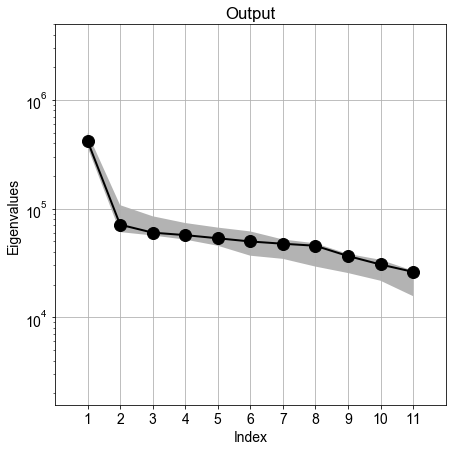

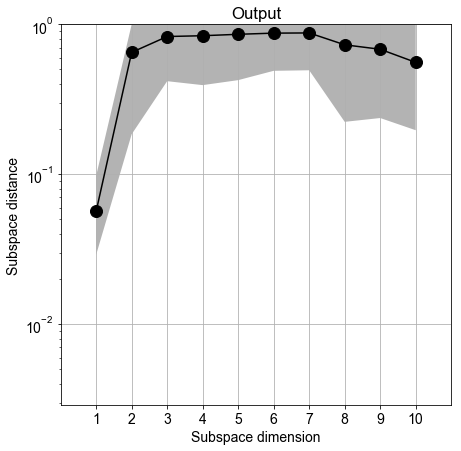

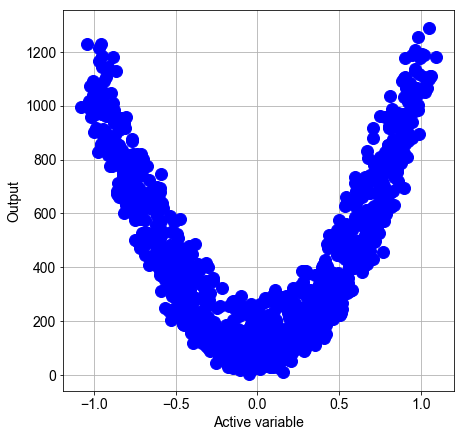

[[ 9.33356443e-03]
 [ 5.89836514e-02]
 [ 4.44651220e-03]
 [-1.27902986e-02]
 [-4.21517643e-02]
 [ 3.19247065e-02]
 [ 1.16556085e-02]
 [-2.12568979e-02]
 [-6.62608053e-05]
 [-1.05840579e-02]
 [ 9.96370793e-01]]
(11,)
(array([ 9.33356443e-03,  5.89836514e-02,  4.44651220e-03, -1.27902986e-02,
       -4.21517643e-02,  3.19247065e-02,  1.16556085e-02, -2.12568979e-02,
       -6.62608053e-05, -1.05840579e-02,  9.96370793e-01]), array([ 0.15103621, -0.12536311, -0.10451322, -0.39623775, -0.08534538,
       -0.28445798, -0.02093334,  0.1285844 ,  0.82433945, -0.09357896,
        0.00893908]))


In [3]:
# USING LOCAL LINEAR APPROXIMATIONS TO GRAD(F)

#Instantiate a subspace object
ss = ac.subspaces.Subspaces()

df = ac.gradients.local_linear_gradients(a, pert_f) #Estimated gradients using local linear models

ss.compute(df=df, nboot=100)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(a.dot(ss.W1), pert_f)

print(ss.W1)
print(np.shape(ss.W1[:,0]))
print(ss.eigenvecs[:,0],ss.eigenvecs[:,1])

# Fitting a Polynomial Surrogate

The R^2 value of the response surface is 0.8977


active_subspaces/utils/response_surfaces.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_weights = np.linalg.lstsq(B, f)[0]


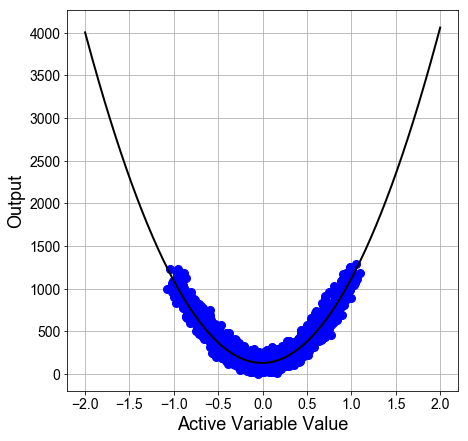

In [4]:
#quadratic polynomial approximation
RS = ac.utils.response_surfaces.PolynomialApproximation(2)

#Train the surface with active variable values (y = a.dot(ss.W1)) and perturbed function values (f)
y = a.dot(ss.W1)
RS.train(y, pert_f)
print 'The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr)

#Plot the data and response surface prediction
plt.figure(figsize=(7, 7))
y0 = np.linspace(-2, 2, 200)
plt.plot(y, pert_f, 'bo', y0, RS.predict(y0[:,None])[0], 'k-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Active Variable Value', fontsize=18)
plt.ylabel('Output', fontsize=18)
plt.show()

# Minimize the Surrogate

In [5]:
#Minimize using the response surface

avdom = ac.domains.BoundedActiveVariableDomain(ss)
avmap = ac.domains.BoundedActiveVariableMap(avdom)
ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,1))[0], avdom) # had to change (1,1) to (1,3)
print 'The response surface optimization results are\n: ystar = {:.4f}, fstar = {:.4f}\n'.\
    format(ystar[0,0], fstar[0,0])


The response surface optimization results are
: ystar = -0.0072, fstar = 130.7358



# Build STAR function

In [6]:
def STARS(x_init,F,k,mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # note that lower f's are evaluations of F(*)
    # k: noise parameter
    # mu_star: smoothing parameter
    # h: step length
    

    
    # Evaluate noisy F(x_init)
    f = F(x_init) + k*(2*np.random.rand(1)-1)
    
    # Draw a random vector of same size as x_init
    u = np.random.normal(0,1,np.size(x_init))
    
    # Form vector y, which is a random walk away from x_init
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y) + k*(2*np.random.rand(1) -1)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x) + k*(2*np.random.rand(1) -1)
    
        
    return [x, f, y, g]

## Test Functions

In [7]:
def function1(a):
    
    a = a[0]
    
    x = a[0]; y = a[1]; z = a[2]; w = a[3]; p = a[4]; q = a[5];
    x1 = a[6]; x2=a[7]; x3=a[8]; x4=a[9]; x5=a[10]
    
    return (x**2+0.5*y**2+4*z**2+(1/8)*w**2+16*p**2+(1/32)*q**2+64*x1**2+(1/128)*x2**2+256*x3**2+(1/512)*x4**2+1024*x5**2)

In [8]:
# Draw a single x_init to seed all experiments with same value below

x_init=2*np.random.rand(1,11)-np.ones(11)

print(x_init, function1(x_init))

(array([[ 0.31795581, -0.10343793, -0.95861258, -0.15181135,  0.07976685,
         0.82754529,  0.86966821,  0.73906928,  0.19903666,  0.57398395,
         0.76627546]]), 663.7006049024985)


# Derivative-Free Optimization using STARS Algorithm by Chen and Wild #

## Algorithm 0

### Pure STARS

In [9]:
# STARS Algorithm #


F=function1
mu_star=1e-4
h=1e-4
k=1e-4

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)

maxit=500

for i in range(1, maxit):
    s=STARS(x,F,k,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    f_hist=np.vstack((f_hist,f))
    
print(x,f)

(array([[ 4.00531022e-02, -4.38235796e-02, -6.20483439e-01,
        -2.39772551e-01,  1.12995491e-01,  8.97188036e-01,
         1.08612563e-02,  3.36694488e-01, -2.92347596e-04,
         1.00982504e+00, -4.83983468e-04]]), array([1.75469169]))


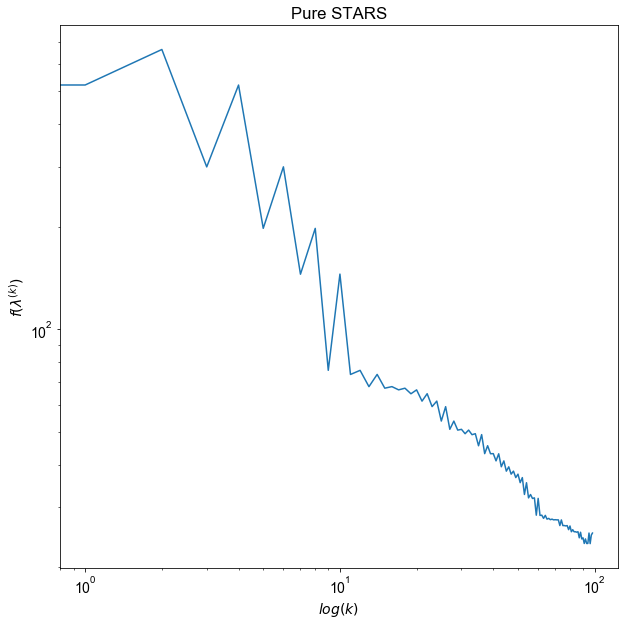

In [28]:
plt.loglog(f_hist)

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('$log(k)$')
plt.ylabel('$f(\lambda^{(k)})$')
plt.title('Pure STARS')
plt.show()

# Use STARS and Active Subspace Analysis Together

## Algorithm 1

### Using the Active Subspace already computed above
### Run STARS maxit times, then project iterate into the already-computed A.S.
### Repeat this Maxit times

In [11]:
# Iterate both STARS and AS in tandem

# This algorithm assumes AS has already been computed

# We run STARS maxit times, project the resulting iterate into the AS, and repeat.

# Initialize
#x_init=2*np.random.rand(1,16)-np.ones(16)
F=function1
mu_star=2e-4
h=3.9e-5
k=1e-4

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)

# Set iteration counters
maxit=250
Maxit=4

for i in range(1,Maxit):
    
    # STARS

    for i in range(1, maxit):
        s=STARS(x,F,k,mu_star,h)
        x=s[0]
        f=s[1]
        x_hist=np.vstack((x_hist,x))
        f_hist=np.vstack((f_hist,f))
    

    
    # Project the new x value into the active subspace ss.W1
    
    x=(x.reshape((1, 11)).dot(ss.W1))*ss.W1
    x=x.reshape(1,11)
    
    f=F(x) + k*(2*np.random.rand(1,1) -1)

print(x)    
print(f)

[[ 1.05535898e-06  6.66936264e-06  5.02773254e-07 -1.44621667e-06
  -4.76615800e-06  3.60977050e-06  1.31791570e-06 -2.40354670e-06
  -7.49220045e-09 -1.19675400e-06  1.12661017e-04]]
[[1.9666148e-05]]


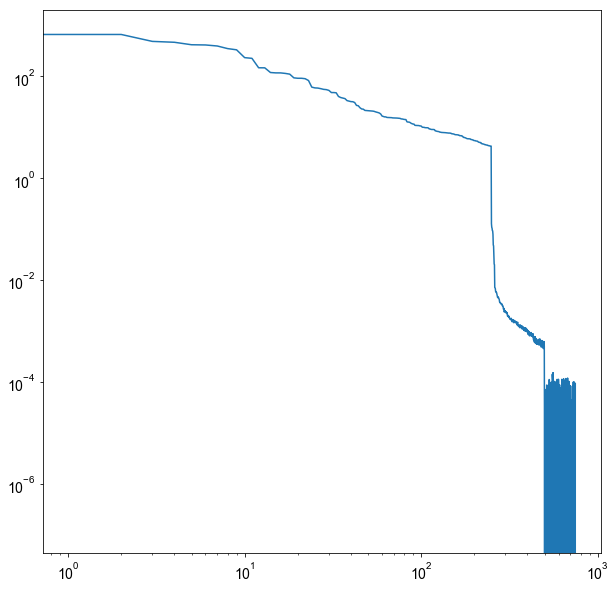

In [12]:
plt.loglog(f_hist)
plt.show()

## Re-Build STAR function with customizable random vector

In [13]:
def STARS_RV(x_init,F,u,k,mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # u: Choice of random vector; probably comes from active subspace
    # note that lower f's are evaluations of F(*)
    # k: noise parameter
    # mu_star: smoothing parameter
    # h: step length
    

    
    # Evaluate noisy F(x_init)
    f = F(x_init) + k*(2*np.random.rand(1)-1)
    
    
    # Form vector y, which is a random walk away from x_init
    # in the direction of u, which the user defines
    sclr=np.random.normal(0,1)
    u=sclr*u
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y) + k*(2*np.random.rand(1) -1)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x) + k*(2*np.random.rand(1) -1)
    
        
    return [x, f, y, g]

## Algorithm 2

### Using the Active Subspace already computed above
### Run STARS_RV maxit times, moving iterates into the direction of the already-computed A.S.
### Repeat this Maxit times

In [14]:
# This algorithm assumes AS has already been computed

# We run STARS_RV maxit times.

# Instead of projecting the iterate, we make the random vector u from STARS
# step in the direction of the AS. This is done by only drawing a scalar value off of N(0,1)
# and using it as the coefficient to the vector "sub," the first principal vector computed from the AS


# We initialize the random vector u==ss.W1, the eigenvector from A.S. calculation above
# Warning: Right now this is just one vector; could be several of them with a different f

sub=ss.W1[:,0]

#sub=np.random.normal(0,1,16)

print(sub)

[ 9.33356443e-03  5.89836514e-02  4.44651220e-03 -1.27902986e-02
 -4.21517643e-02  3.19247065e-02  1.16556085e-02 -2.12568979e-02
 -6.62608053e-05 -1.05840579e-02  9.96370793e-01]


In [15]:
# Initialize
#x_init=2*np.random.rand(1,16)-np.ones(16)
F=function1
mu_star=1e-4
h=1e-4
k=1e-4

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)

# Set iteration counter
maxit=1000

for i in range(1,maxit):
    s=STARS_RV(x,F,sub,k,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    f_hist=np.vstack((f_hist,f))
    
print(x,f)

(array([[ 3.10772173e-01, -1.48835068e-01, -9.62034869e-01,
        -1.41967213e-01,  1.12209213e-01,  8.02974240e-01,
         8.60697394e-01,  7.55429786e-01,  1.99087656e-01,
         5.82130038e-01, -5.87508425e-04]]), array([61.56942182]))


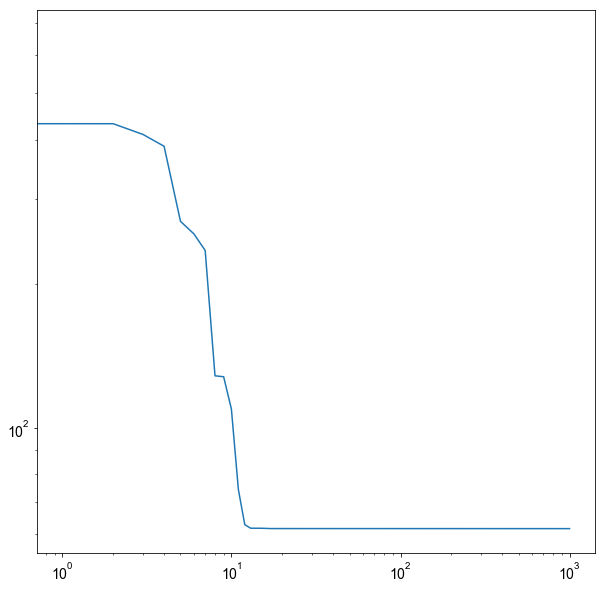

In [16]:
plt.loglog(f_hist)
plt.show()

## Algorithm 3

### Learns Active Subspace by storage of all $x$ and $f(x)$ values
### Run STARS maxit times, compute A.S. using data, moves iterates in direction of A.S.
### Repeat this Maxit times

In [17]:
# This algorithm assumes AS has NOT already been computed

# We run STARS maxit times, compute AS with those f values.

# Instead of projecting the iterate, we instead only let the random vector u
# step in the direction of the AS. This is done by only drawing a scalar value off of N(0,1)
# and using it as the coefficient to the vector "sub," the first principal vector computed from the AS


# Initialize
#x_init=2*np.random.rand(1,16)-np.ones(16)
F=function1
mu_star=1e-4
h=1e-4
k=1e-4

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)

# Set iteration counter
maxit=100
Maxit=10

# We initialize the random vector u==sub, since we don't know the AS yet
sub=np.random.normal(0,1,11)

for i in range(1,Maxit):
    
    for i in range(1,maxit):
        s=STARS_RV(x,F,sub,k,mu_star,h)
        x=s[0]
        f=s[1]
        y=s[2]
        g=s[3]
        x_hist=np.vstack((x_hist,x))
        x_hist=np.vstack((x_hist,y))
        f_hist=np.vstack((f_hist,f))
        f_hist=np.vstack((f_hist,g))
    
    # Compute AS using function values stored in f_hist
    
    # Instantiate a subspace object
    ss = ac.subspaces.Subspaces()

    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')
    
    sub=ss.eigenvecs[:,0]
    
print(x)    
print(f)
print(sub)

[[ 0.01496797 -0.15708183 -0.25146174 -0.85675284  0.11146817  0.15898477
   0.29486738  1.43302046  0.15256736  0.38017104  0.02761245]]
[12.76840049]
[ 0.00066209 -0.5760257  -0.15927335  0.31708567  0.17067986  0.18152867
 -0.22985404  0.61629708 -0.16528605 -0.13073077  0.0559766 ]


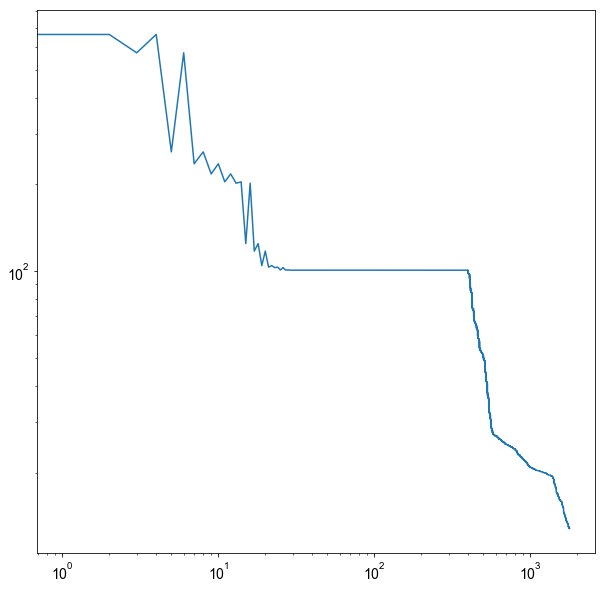

In [18]:
plt.loglog(f_hist)
plt.show()

# Algo. 4

## same as above, but with a regular STARS burn-in phase

[[ 0.29885121  0.06230782 -1.25911957  0.02900789  0.14784876  0.47318457
   0.46734851  0.89517932  0.05306493  0.88217486 -0.05766172]]
[24.88658867]
(99, 1)
(array([ 3.01207467e-03,  1.78304518e-03, -1.04493900e-02,  3.29787377e-03,
       -3.21533381e-03,  3.10308691e-03, -5.69964717e-03,  4.26894730e-04,
        1.48894547e-02, -9.75512149e-03,  9.99749063e-01]), array([ 0.0046192 , -0.0749833 , -0.04339449, -0.0192434 , -0.03299634,
       -0.02786778,  0.08561527, -0.0054408 , -0.98771721, -0.0842262 ,
        0.01408895]), array([ 0.05271181, -0.30394136, -0.05908721, -0.19216939, -0.10040698,
       -0.10644722,  0.89815139,  0.11499889,  0.12110662, -0.09183115,
        0.00277868]), array([ 0.20323278, -0.29417452, -0.65249548, -0.0968963 , -0.04535979,
        0.41116828, -0.21354959,  0.3931521 ,  0.04440277, -0.25219316,
       -0.01251743]))


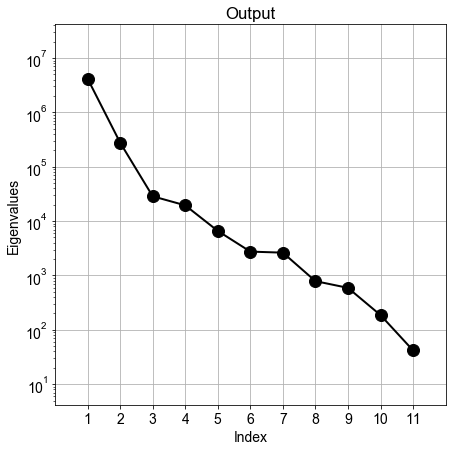

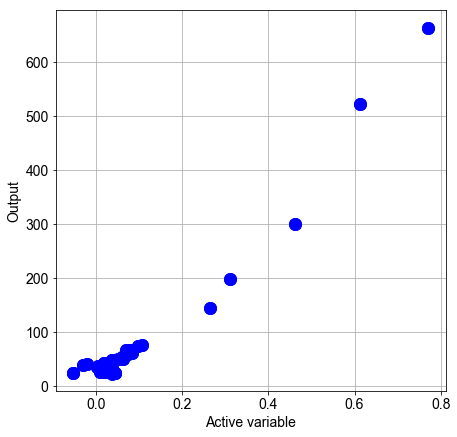

In [19]:
# This algorithm assumes AS has NOT already been computed

# STARS burn-in followed by active subspace calculation

#x_init=2*np.random.rand(1,16)-np.ones(16)
F=function1
mu_star=1e-4
h=1e-4
k=1e-4

x=x_init
f=F(x)

x_hist=np.array(x)
f_hist=np.array(f)
my_f_hist=np.array(f)

maxit=50

for i in range(1, maxit):
    s=STARS(x,F,k,mu_star,h)
    x=s[0]
    f=s[1]
    y=s[2]
    g=s[3]
    x_hist=np.vstack((x_hist,x))
    x_hist=np.vstack((x_hist,y))
    f_hist=np.vstack((f_hist,f))
    my_f_hist=np.vstack((my_f_hist,f))
    f_hist=np.vstack((f_hist,g))
            
    
# Compute AS using function values stored in f_hist
    
# Instantiate a subspace object
ss = ac.subspaces.Subspaces()

# Use Local Linears
#df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
#ss.compute(df=df, nboot=0)
    
# Use Global Quadratic
ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')


sub=ss.eigenvecs[:,0]
sub1=ss.eigenvecs[:,1]
sub2=ss.eigenvecs[:,2]
sub3=ss.eigenvecs[:,3]
    
# Project the new x value into the active subspace ss.W1
    
#x=(x.reshape((1, 16)).dot(sub))*sub
#x=x.reshape(1,16)
#x_hist=np.vstack((x_hist,x))
    
    
#f=F(x) + k*(2*np.random.rand(1,1) -1)
#f_hist=np.vstack((f_hist,f))

print(x)    
print(f)
print(np.shape(f_hist))
print(sub,sub1,sub2,sub3)


ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
#ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(x_hist.dot(ss.W1), f_hist)

In [20]:
# Initialize
F=function1
mu_star=1e-3
h=1e-4
k=1e-4

x_hist=np.array(x)
#f_hist=np.array(f)

# Set iteration counter
maxit=25

#for i in range(1,maxit):
 #   s=STARS_RV(x,F,sub,k,mu_star,h)
  #  x=s[0]
   # f=s[1]
    #x_hist=np.vstack((x_hist,x))
    #f_hist=np.vstack((f_hist,f))
    
#print(x,f)

#print(np.max(f_hist),np.min(f_hist))

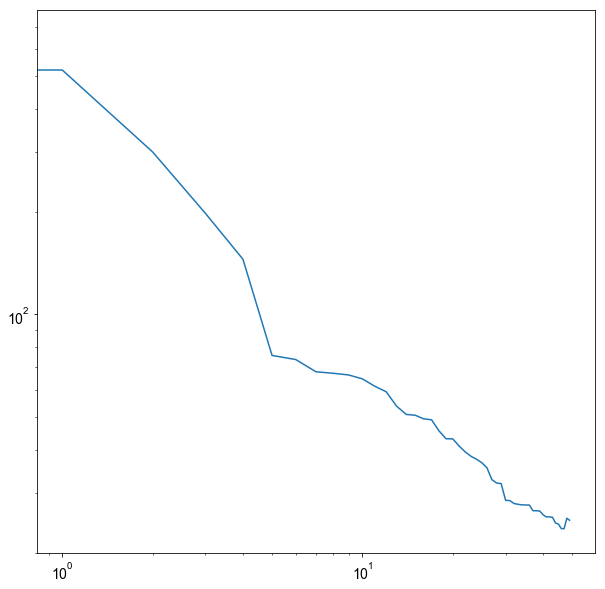

In [21]:
plt.loglog(my_f_hist)
plt.show()

In [22]:
# Initialize
F=function1
mu_star=1e-2
h=1e-3
k=1e-4

x_hist=np.array(x)
#f_hist=my_f_hist

# Set iteration counter
maxit=1

for i in range(1,maxit):
    s=STARS_RV(x,F,sub1,k,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    my_f_hist=np.vstack((my_f_hist,f))
    
print(x,f)

print(np.min(my_f_hist))

(array([[ 0.29885121,  0.06230782, -1.25911957,  0.02900789,  0.14784876,
         0.47318457,  0.46734851,  0.89517932,  0.05306493,  0.88217486,
        -0.05766172]]), array([24.88658867]))
23.51516525350555


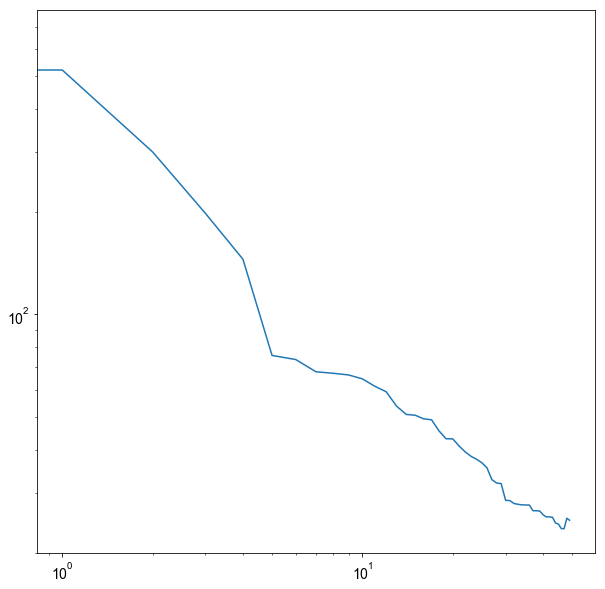

In [23]:
plt.loglog(my_f_hist)
plt.show()

In [24]:
# Initialize
F=function1
mu_star=1e-2
h=1e-3
k=1e-4

x_hist=np.array(x)
#f_hist=np.array(f)

# Set iteration counter
maxit=5

for i in range(1,maxit):
    s=STARS_RV(x,F,sub2,k,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    my_f_hist=np.vstack((my_f_hist,f))
    
print(x,f)

print(np.min(my_f_hist))

(array([[ 0.29303262,  0.09585837, -1.25259723,  0.0502205 ,  0.15893217,
         0.48493474,  0.36820613,  0.88248517,  0.03969658,  0.89231163,
        -0.05796844]]), array([19.29195277]))
19.29195277371594


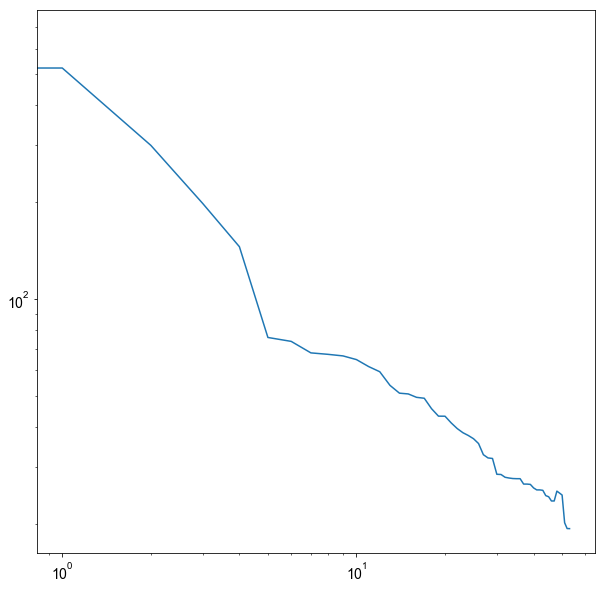

In [25]:
plt.loglog(my_f_hist)
plt.show()

In [26]:
# Initialize
F=function1
mu_star=1e-2
h=1e-3
k=1e-4

x_hist=np.array(x)
#f_hist=np.array(f)

# Set iteration counter
maxit=40

for i in range(1,maxit):
    s=STARS_RV(x,F,sub3,k,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.vstack((x_hist,x))
    my_f_hist=np.vstack((my_f_hist,f))
    
print(x,f)

print(np.min(my_f_hist))

(array([[ 0.30200288,  0.08287413, -1.28139701,  0.0459437 ,  0.15693009,
         0.50308284,  0.3587805 ,  0.89983808,  0.04165642,  0.88118036,
        -0.05852094]]), array([19.24592755]))
19.245927554275877


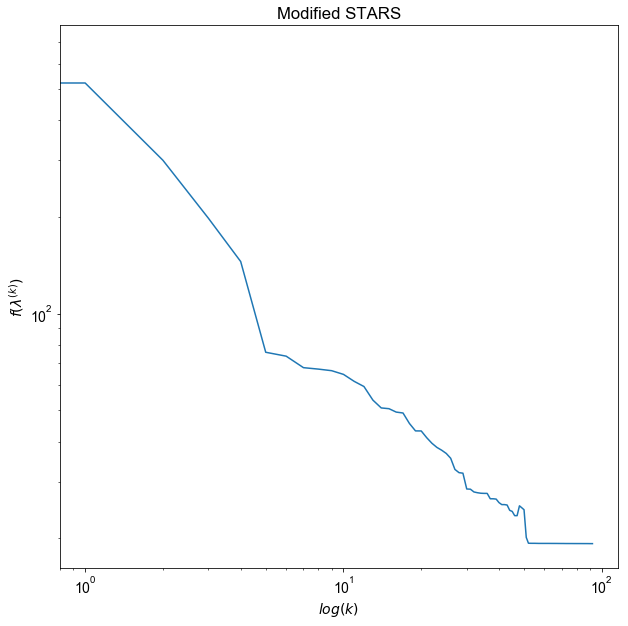

In [27]:
plt.loglog(my_f_hist)

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('$log(k)$')
plt.ylabel('$f(\lambda^{(k)})$')
plt.title('Modified STARS')
plt.show()